In [4]:
!pip install tensorflow

In [5]:
!pip install opencv-python

**after data augmentation now its time for data preparation**

**1.I converted all image in gray color space reduced one dimension because color is not that much important in my case**

** resized all Image **

**converted Y into One hot encoding**

In [23]:
def prepare_dataset(base_dir, img_size=(224, 224)):
    classes = os.listdir(base_dir)
    X = []
    y = []
    for class_index, class_name in enumerate(classes):
        class_dir = os.path.join(base_dir, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)

            # Load image
            img = cv2.imread(img_path)

            if img is None:
                print(f"Warning: Could not read image {img_path}. Skipping.")
                continue

            # Convert to grayscale if necessary
            if len(img.shape) == 3:
                gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            else:
                gray_img = img

            # Resize image
            resized_img = cv2.resize(gray_img, img_size)

            # Normalize pixel values to range [0, 1]
            normalized_img = resized_img.astype('float32') / 255.0

            X.append(normalized_img)
            y.append(class_index)

    X = np.array(X)
    y = np.array(y)
    X = X.reshape(X.shape[0], img_size[0], img_size[1], 1)
    y = to_categorical(y)
    return X, y, classes

# Load training and validation datasets
train_dir = '/content/drive/MyDrive/training'
val_dir = '/content/drive/MyDrive/validation'  # Adjust this path to your validation directory

X_train, y_train, classes = prepare_dataset(train_dir)
X_val, y_val, _ = prepare_dataset(val_dir)
print(y_train)

print("Training Dataset shape:", X_train.shape)
print("Training Labels shape:", y_train.shape)
print("Validation Dataset shape:", X_val.shape)
print("Validation Labels shape:", y_val.shape)
print("Classes:", classes)

[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]
Training Dataset shape: (2937, 224, 224, 1)
Training Labels shape: (2937, 6)
Validation Dataset shape: (300, 224, 224, 1)
Validation Labels shape: (300, 6)
Classes: ['soccer_shoes', 'sandals', 'flip_flops', 'loafers', 'boots', 'sneakers']


In [28]:
y_train[2000]

array([0., 0., 0., 0., 1., 0.], dtype=float32)

**Model Training**

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 224, 224, 64)      640       
                                                                 
 batch_normalization_26 (Ba  (None, 224, 224, 64)      256       
 tchNormalization)                                               
                                                                 
 conv2d_21 (Conv2D)          (None, 224, 224, 32)      18464     
                                                                 
 batch_normalization_27 (Ba  (None, 224, 224, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 112, 112, 32)      0         
 ng2D)                                                           
                                                      

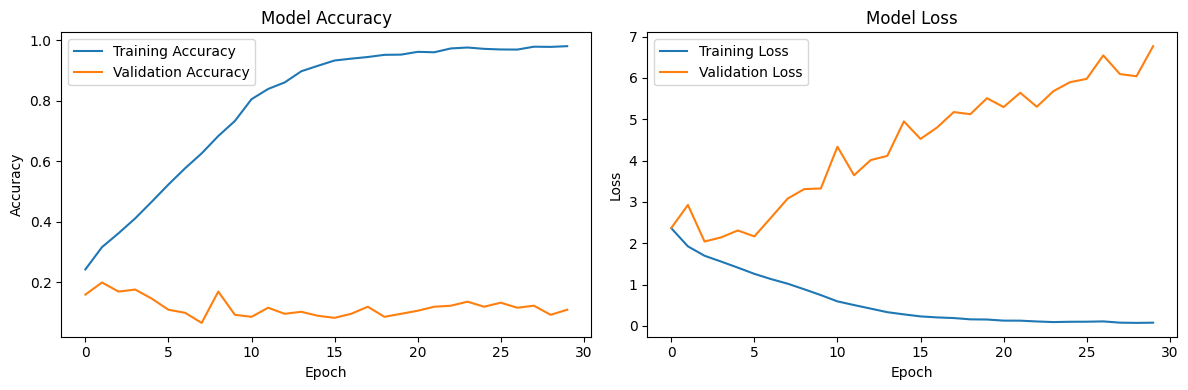

10/10 [==============================] - 1s 47ms/step

Classification Report:
              precision    recall  f1-score   support

soccer_shoes       0.10      0.06      0.07        50
     sandals       0.11      0.14      0.12        50
  flip_flops       0.07      0.06      0.06        50
     loafers       0.14      0.20      0.17        50
       boots       0.10      0.12      0.11        50
    sneakers       0.12      0.08      0.10        50

    accuracy                           0.11       300
   macro avg       0.11      0.11      0.11       300
weighted avg       0.11      0.11      0.11       300


Confusion Matrix:
[[ 3  7  2 10 27  1]
 [ 1  7 28  6  6  2]
 [ 2 13  3 28  4  0]
 [ 4 16  5 10  9  6]
 [ 9  9  2  5  6 19]
 [12 12  6 10  6  4]]

Sample Predictions:
True: soccer_shoes, Predicted: boots
Probabilities: [2.5980921e-02 3.7064347e-01 2.0576356e-02 5.1850822e-02 5.3074747e-01
 2.0094006e-04]

True: soccer_shoes, Predicted: sandals
Probabilities: [0.00454001 0.7598

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Assuming X_train, y_train, X_val, y_val, and classes are already defined

# Randomize the order of training data
indices = np.arange(X_train.shape[0])
np.random.shuffle(indices)
X_train = X_train[indices]
y_train = y_train[indices]

def create_model(input_shape, num_classes):
    model = Sequential([
        # First convolutional block
        Conv2D(64, (3, 3), padding='same', input_shape=input_shape),
        BatchNormalization(),
        Conv2D(32, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Second convolutional block
        Conv2D(64, (3, 3), padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Third convolutional block
        Conv2D(128, (3, 3), padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Flatten and dense layers
        Flatten(),
        Dense(128),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Create and compile the model
input_shape = (224, 224, 1)
num_classes = len(classes)
model = create_model(input_shape, num_classes)

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

# Check class distribution
print("Class distribution in training set:")
for i, class_name in enumerate(classes):
    print(f"{class_name}: {np.sum(y_train[:, i])}")

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=30,
                    batch_size=32)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_val, y_val)
print(f"Test accuracy: {test_accuracy:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Check predictions on validation set
val_predictions = model.predict(X_val)
val_predicted_classes = np.argmax(val_predictions, axis=1)
val_true_classes = np.argmax(y_val, axis=1)

print("\nClassification Report:")
print(classification_report(val_true_classes, val_predicted_classes, target_names=classes))

print("\nConfusion Matrix:")
print(confusion_matrix(val_true_classes, val_predicted_classes))

# Look at sample predictions
print("\nSample Predictions:")
for i in range(10):  # Check first 10 validation images
    true_class = classes[np.argmax(y_val[i])]
    pred_class = classes[np.argmax(val_predictions[i])]
    print(f"True: {true_class}, Predicted: {pred_class}")
    print(f"Probabilities: {val_predictions[i]}")
    print()

# Check if the model is predicting the same class for all inputs
unique_predictions, counts = np.unique(val_predicted_classes, return_counts=True)
print("\nPrediction distribution:")
for class_id, count in zip(unique_predictions, counts):
    print(f"Class {classes[class_id]}: {count} predictions")

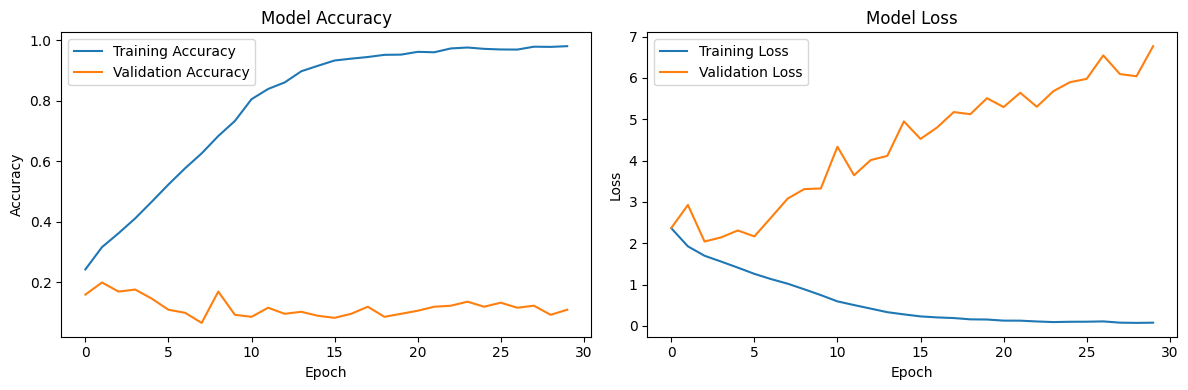

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [32]:
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical

def predict_image(model, image_path, img_size=(224, 224), classes=None):
    # Load image
    img = cv2.imread(image_path)

    if img is None:
        print(f"Error: Could not read image {image_path}")
        return None, None

    # Convert to grayscale if necessary
    if len(img.shape) == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray_img = img

    # Resize image
    resized_img = cv2.resize(gray_img, img_size)

    # Normalize pixel values to range [0, 1]
    normalized_img = resized_img.astype('float32') / 255.0

    # Reshape to match model input shape
    input_img = normalized_img.reshape(1, img_size[0], img_size[1], 1)

    # Make prediction
    predictions = model.predict(input_img)

    # Get the predicted class
    predicted_class_index = np.argmax(predictions[0])

    # Get the class name
    if classes:
        predicted_class_name = classes[predicted_class_index]
    else:
        predicted_class_name = f"Class {predicted_class_index}"

    # Get the confidence score
    confidence = predictions[0][predicted_class_index]

    return predicted_class_name, confidence

# Example usage:
image_path = '/content/drive/MyDrive/validation/sneakers/image267.jpg'
classes = ['soccer_shoes', 'sandals', 'flip_flops', 'loafers', 'boots', 'sneakers']

predicted_class, confidence = predict_image(model, image_path, img_size=(224, 224), classes=classes)
if predicted_class is not None:
    print(f"Predicted class: {predicted_class}")
    print(f"Confidence: {confidence:.2f}")

1/1 [==============================] - 0s 30ms/step
Predicted class: sneakers
Confidence: 0.97


In [33]:
model.save('/content/drive/MyDrive/my_model_updated.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
